In [2]:
import baltic as bt
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime as dt
from datetime import timedelta
import time
#import pymc3
import math
import arviz as az
import re
#from hpd import hpd
import scipy.stats as stats
from io import StringIO
import altair as alt
from altair import datum
from sklearn.linear_model import LinearRegression
import seaborn as sns
import scipy as sp
from scipy.stats import pearsonr
from scipy.interpolate import splrep, BSpline
from matplotlib import pyplot 


alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')


### Load Log files

In [3]:
from datetime import date
current_date = str(date.today())

In [4]:
log_file_path = "../../../mpox_rhino/monthly_pred/combined_exp_glm.log"


In [5]:
domain = ['CentralEurope', 'NorthAmerica', 'SouthAmerica' ,"SouthernEurope", "WesternEurope"]
range_ = ['#EEC060', '#2664A5', '#A76BB1', "#EEA160", "#356D4C"]

## we can then estimate the transmission rates via the change in Ne's over time plus the uninfectious rate

In [6]:
def read_in_Ne_changes_mascot(log_file_path):
    
    Ne_skyline_dict = {"sample":[]}
    
    with open(log_file_path, "r") as infile:
        line_number = 0
        for line in infile:
            line_number += 1
            if not line.startswith("#"):  # log combiner will sometimes put the entire xml at the start of the log file
                # use the first line to find the migration rate columns
            
            # use the first line to find the migration rate columns
                if "posterior" in line:
                    all_cols = line.split("\t")
                    Ne_column_indices = []   # list to store column indices
                    Nes_key = {}   # dictionary to store the column index to map to column name

                    for i in range(len(all_cols)):
                        col = all_cols[i]
                        if "Ne." in col:
                            Ne_column_indices.append(i)

                    # make an empty dictionary to store Nes and generate dictionary to convert index to name
                    for n in Ne_column_indices:
                        name = line.split("\t")[n]
                        deme = name.split(".")[1]# the syntax here is "NeLog.state01" where 0 is deme and 1 is interval 1
                        interval = name.split(".")[2]
                       
                        Nes_key[n] = name
                        Ne_skyline_dict[name] = []


                # read in actual parameter estimates and store in dictionary
                else:
                    sample = line.split("\t")[0]
                    Ne_skyline_dict["sample"].append(sample)

                    for index in Ne_column_indices:
                        name = Nes_key[index]
                        Ne_skyline_dict[name].append(line.split("\t")[index])
                    
                
    return(Ne_skyline_dict)

In [7]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_summary_df(input_df):
    
    
    new_df = pd.DataFrame()
    
    for i in input_df.columns.tolist():
        if "Ne" in i:
            deme = i.split(".")[1]
            #print(deme)
            interval = i.split(".")[2]
            #print(interval)
            #print(i)
            next_interval = int(interval)+7
            local_series = input_df[i].astype('float').to_numpy()
            #print(local_series)
            mean_log = local_series.mean()
            mean_linear = 10**mean_log
            hpd_95 = az.hdi(local_series, 0.95)
            lower_hpd_log_95 = hpd_95[0]
            lower_hpd_linear_95 = 10**lower_hpd_log_95
            upper_hpd_log_95 = hpd_95[1]
            upper_hpd_linear_95 = 10**upper_hpd_log_95
            hpd_50 = az.hdi(local_series, 0.50)
            lower_hpd_log_50 = hpd_50[0]
            lower_hpd_linear_50 = 10**lower_hpd_log_50
            upper_hpd_log_50 = hpd_50[1]
            upper_hpd_linear_50 = 10**upper_hpd_log_50
            
            try:
                next_local_series = input_df["Ne"+"."+ str(deme) +"." + str(next_interval)].astype('float').to_numpy()
                diff_series = np.subtract(local_series, next_local_series)
                #print(local_series)
                #print(next_local_series)
                #print(diff_series)
                diff_mean_log = diff_series.mean()
                diff_hpd_95 = az.hdi(diff_series, 0.95)
                diff_lower_hpd_log_95 = diff_hpd_95[0]
                diff_lower_hpd_linear_95 = math.exp(diff_lower_hpd_log_95)
                diff_upper_hpd_log_95 = diff_hpd_95[1]
                diff_upper_hpd_linear_95 = math.exp(diff_upper_hpd_log_95)
                diff_hpd_50 = az.hdi(diff_series, 0.50)
                diff_lower_hpd_log_50 = diff_hpd_50[0]
                diff_lower_hpd_linear_50 = math.exp(diff_lower_hpd_log_50)
                diff_upper_hpd_log_50 = diff_hpd_50[1]
                diff_upper_hpd_linear_50 = math.exp(diff_upper_hpd_log_50)
            except KeyError:
                pass   
            
            try:
                local_df = pd.DataFrame.from_dict({"deme":deme, "interval":interval, "mean_Ne_log":mean_log,"mean_Ne_linear":mean_linear, 
                                                   "upper_hpd_log_95":upper_hpd_log_95,"lower_hpd_log_95":[lower_hpd_log_95], 
                                                   "upper_hpd_log_50":upper_hpd_log_50,"lower_hpd_log_50":lower_hpd_log_50,
                                                   "upper_hpd_linear":upper_hpd_linear_95,"lower_hpd_linear":lower_hpd_linear_95,
                                                   "diff_mean_Ne_log":diff_mean_log, 
                                                   "diff_upper_hpd_log_95":diff_upper_hpd_log_95,"diff_lower_hpd_log_95":diff_lower_hpd_log_95, 
                                                   "diff_upper_hpd_log_50":diff_upper_hpd_log_50,"diff_lower_hpd_log_50":diff_lower_hpd_log_50,
                                                   "diff_upper_hpd_linear":diff_upper_hpd_linear_95,"diff_lower_hpd_linear":diff_lower_hpd_linear_95,
                                                   "diff_upper_hpd_linear_50":diff_upper_hpd_linear_50,"diff_lower_hpd_linear_50":diff_lower_hpd_linear_50})
                new_df = new_df.append(local_df)
                #print(new_df)
            except:
                pass
            
    return(new_df)

In [8]:
Ne_skyline = read_in_Ne_changes_mascot(log_file_path)

In [9]:
Ne_df = pd.DataFrame.from_dict(Ne_skyline)
print(len(Ne_df))
burnin_percent = 0.3

rows_to_remove = int(len(Ne_df)* burnin_percent)
Ne_df = Ne_df.iloc[rows_to_remove:]

print(len(Ne_df))
Ne_df = Ne_df.reset_index()
Ne_df

25086
17561


,index,sample,Ne.CentralEurope.0,Ne.CentralEurope.1,Ne.CentralEurope.2,Ne.CentralEurope.3,Ne.CentralEurope.4,Ne.CentralEurope.5,Ne.CentralEurope.6,Ne.CentralEurope.7,...,Ne.WesternEurope.34,Ne.WesternEurope.35,Ne.WesternEurope.36,Ne.WesternEurope.37,Ne.WesternEurope.38,Ne.WesternEurope.39,Ne.WesternEurope.40,Ne.WesternEurope.41,Ne.WesternEurope.42,Ne.WesternEurope.43
0,7525,37625000,7.959261406460462E-4,0.0010849929047639113,0.0014554608392312682,0.002018312321407611,0.002714190691580449,0.009989015557719815,0.01341038974217268,0.01796817466280063,...,0.7491185445441986,0.0823203990102302,0.0823203990102302,0.0823203990102302,0.0823203990102302,0.0823203990102302,0.0823203990102302,0.0823203990102302,0.0823203990102302,0.0823203990102302
1,7526,37630000,0.003375873087768192,0.0045319096307768324,0.005991579533069123,0.008175273399488255,0.010833963400236925,0.025671744013792148,0.033965926590041114,0.0448557146714563,...,1.264455119042354,0.12987810388403492,0.12987810388403492,0.12987810388403492,0.12987810388403492,0.12987810388403492,0.12987810388403492,0.12987810388403492,0.12987810388403492,0.12987810388403492
2,7527,37635000,0.00546023578838177,0.0073300430769567,0.00969095583419225,0.013222926109820763,0.01752316901436015,0.02335101938542862,0.03089540818971946,0.04080075986569907,...,1.1883704373801642,0.12206309009660239,0.12206309009660239,0.12206309009660239,0.12206309009660239,0.12206309009660239,0.12206309009660239,0.12206309009660239,0.12206309009660239,0.12206309009660239
3,7528,37640000,0.006240010324241967,0.008297639210491032,0.0108718334413861,0.01468621606290276,0.01928635166386065,0.02582742726391834,0.03386466738183906,0.04432257206286235,...,1.4115048076632215,0.11732317116913812,0.11732317116913812,0.11732317116913812,0.11732317116913812,0.11732317116913812,0.11732317116913812,0.11732317116913812,0.11732317116913812,0.11732317116913812
4,7529,37645000,0.003073606925267288,0.004038542802255646,0.0052317798147682735,0.006978736726481926,0.009060494280074828,0.029436950953117373,0.03816117149370209,0.04938511705581086,...,1.4791714875115565,0.12294757246001045,0.12294757246001045,0.12294757246001045,0.12294757246001045,0.12294757246001045,0.12294757246001045,0.12294757246001045,0.12294757246001045,0.12294757246001045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17556,25081,125405000,0.0014578545609649446,0.002022967618090208,0.002759831859040805,0.0038995780065294154,0.005333981916503512,0.0071485119318690435,0.009760548491673656,0.013299261508660672,...,0.9584345988724887,0.08053892768339284,0.08053892768339284,0.08053892768339284,0.08053892768339284,0.08053892768339284,0.08053892768339284,0.08053892768339284,0.08053892768339284,0.08053892768339284
17557,25082,125410000,4.193838681773469E-4,5.819510447672055E-4,7.9392621977155E-4,0.0011217992195017995,0.0015344369931185823,0.009458005129279657,0.012913920908109272,0.017595897546701968,...,1.0368106309582077,0.08878290124166786,0.08878290124166786,0.08878290124166786,0.08878290124166786,0.08878290124166786,0.08878290124166786,0.08878290124166786,0.08878290124166786,0.08878290124166786
17558,25083,125415000,0.0016489766941529837,0.002288175065315819,0.0031216408942240322,0.004410805729168466,0.006033257433804643,0.005866977830079754,0.00801074715351217,0.010915065005332443,...,1.0988240818905104,0.09409316130785694,0.09409316130785694,0.09409316130785694,0.09409316130785694,0.09409316130785694,0.09409316130785694,0.09409316130785694,0.09409316130785694,0.09409316130785694
17559,25084,125420000,0.008092471989074469,0.010495882249194772,0.013430668295855062,0.017671558147639325,0.02265993374515072,0.04254654858616235,0.0544794424400196,0.06964378490623266,...,0.671184292869253,0.08756479641071951,0.08756479641071951,0.08756479641071951,0.08756479641071951,0.08756479641071951,0.08756479641071951,0.08756479641071951,0.08756479641071951,0.08756479641071951


## calculating transmission rate

In [10]:
def generate_summary_diff_df(input_df):
    
    
    new_df = pd.DataFrame()
   
    for i in input_df.columns.tolist():
        if "Ne" in i:
            deme = i.split(".")[1]
            interval = i.split(".")[2]
            next_interval = int(interval)+3 #averaging over three weeks to reduce noise
            local_series = input_df[i].astype('float').to_numpy()
           
            try:
                new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("float")) - np.log(input_df["Ne"+"."+ str(deme) +"." + str(next_interval)].astype('float')))
            
            
            except KeyError:
                pass 
            
            
    return(new_df)

In [11]:
ne_diff_summary = generate_summary_diff_df(Ne_df)

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("float")) - np.log(input_df["Ne"+"."+ str(deme) +"." + str(next_interval)].astype('float')))
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("floa

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("float")) - np.log(input_df["Ne"+"."+ str(deme) +"." + str(next_interval)].astype('float')))
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("floa

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("float")) - np.log(input_df["Ne"+"."+ str(deme) +"." + str(next_interval)].astype('float')))
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("floa

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("float")) - np.log(input_df["Ne"+"."+ str(deme) +"." + str(next_interval)].astype('float')))
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("floa

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("float")) - np.log(input_df["Ne"+"."+ str(deme) +"." + str(next_interval)].astype('float')))
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("floa

In [12]:
ne_diff_summary

,Ne.CentralEurope.diff.0,Ne.CentralEurope.diff.1,Ne.CentralEurope.diff.2,Ne.CentralEurope.diff.3,Ne.CentralEurope.diff.4,Ne.CentralEurope.diff.5,Ne.CentralEurope.diff.6,Ne.CentralEurope.diff.7,Ne.CentralEurope.diff.8,Ne.CentralEurope.diff.9,...,Ne.WesternEurope.diff.31,Ne.WesternEurope.diff.32,Ne.WesternEurope.diff.33,Ne.WesternEurope.diff.34,Ne.WesternEurope.diff.35,Ne.WesternEurope.diff.36,Ne.WesternEurope.diff.37,Ne.WesternEurope.diff.38,Ne.WesternEurope.diff.39,Ne.WesternEurope.diff.40
0,-16.128850,-15.893286,-33.386833,-32.825313,-32.761877,-14.993176,-9.466528,-9.113445,-9.097490,-14.094915,...,35.378584,67.120029,60.134288,38.276824,0.0,0.0,0.0,0.0,0.0,0.0
1,-15.330643,-15.106738,-25.220622,-24.686891,-24.626594,-14.251173,7.097974,7.433583,7.448749,-13.397366,...,33.627720,66.862977,60.222956,39.447204,0.0,0.0,0.0,0.0,0.0,0.0
2,-15.330643,-15.106738,-15.243758,-14.710027,-14.649730,-14.251173,-8.193055,-7.857445,-7.842279,-13.397366,...,33.627720,66.862977,60.222956,39.447204,0.0,0.0,0.0,0.0,0.0,0.0
3,-14.836077,-14.619395,-14.997868,-14.481356,-14.423004,-13.791431,-3.845761,-3.520978,-3.506302,-12.965168,...,32.542891,69.647651,63.221836,43.116309,0.0,0.0,0.0,0.0,0.0,0.0
4,-14.213613,-14.006022,-29.943319,-29.448478,-29.392574,-13.212796,-2.520329,-2.209172,-2.195112,-12.421200,...,31.177518,68.534499,62.378287,43.116309,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17556,-17.054309,-16.805230,-16.496731,-15.902991,-15.835915,-15.853471,-8.505349,-8.132006,-8.115135,-14.903669,...,37.408577,73.425256,66.038678,42.927052,0.0,0.0,0.0,0.0,0.0,0.0
17557,-17.054309,-16.805230,-42.945521,-42.351782,-42.284706,-15.853471,-6.708074,-6.334731,-6.317860,-14.903669,...,37.408577,73.098519,65.711942,42.600315,0.0,0.0,0.0,0.0,0.0,0.0
17558,-17.054309,-16.805230,-10.937002,-10.343262,-10.276186,-15.853471,-7.250602,-6.877259,-6.860388,-14.903669,...,37.408577,73.098519,65.711942,42.600315,0.0,0.0,0.0,0.0,0.0,0.0
17559,-13.537718,-13.339999,-19.986338,-19.515027,-19.461782,-12.584492,5.202308,5.498668,5.512060,-11.830539,...,29.694945,59.511676,53.648208,35.302188,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
uninfectious_rate = 365/4.5

#taken from https://www.medrxiv.org/content/10.1101/2022.08.17.22278897v1.full.pdf


In [14]:
incubation_period = 365/8

In [15]:
seir_growth_rate = ((ne_diff_summary*2 + uninfectious_rate + incubation_period)**2 - (incubation_period- uninfectious_rate)**2)/(4*incubation_period)



seir_growth_rate



,Ne.CentralEurope.diff.0,Ne.CentralEurope.diff.1,Ne.CentralEurope.diff.2,Ne.CentralEurope.diff.3,Ne.CentralEurope.diff.4,Ne.CentralEurope.diff.5,Ne.CentralEurope.diff.6,Ne.CentralEurope.diff.7,Ne.CentralEurope.diff.8,Ne.CentralEurope.diff.9,...,Ne.WesternEurope.diff.31,Ne.WesternEurope.diff.32,Ne.WesternEurope.diff.33,Ne.WesternEurope.diff.34,Ne.WesternEurope.diff.35,Ne.WesternEurope.diff.36,Ne.WesternEurope.diff.37,Ne.WesternEurope.diff.38,Ne.WesternEurope.diff.39,Ne.WesternEurope.diff.40
0,42.010445,42.499456,12.801264,13.546150,13.631170,44.390422,56.779367,57.616367,57.654319,46.312907,...,206.818254,366.297517,327.408500,219.547737,81.111111,81.111111,81.111111,81.111111,81.111111,81.111111
1,43.677304,44.149891,24.995303,25.894060,25.996380,45.975938,101.931951,102.971091,103.018165,47.830219,...,199.306618,364.828620,327.888702,224.792582,81.111111,81.111111,81.111111,81.111111,81.111111,81.111111
2,43.677304,44.149891,43.860427,44.992607,45.121297,45.975938,59.823884,60.638068,60.674976,47.830219,...,199.306618,364.828620,327.888702,224.792582,81.111111,81.111111,81.111111,81.111111,81.111111,81.111111
3,44.724096,45.186102,44.380471,45.481499,45.606620,46.970427,70.752604,71.602338,71.640845,48.781042,...,194.719863,380.895608,344.332815,241.624196,81.111111,81.111111,81.111111,81.111111,81.111111,81.111111
4,46.056837,46.505081,17.586783,18.317189,18.400380,48.235267,74.249421,75.081489,75.119190,49.989393,...,189.020264,374.432173,339.667431,241.624196,81.111111,81.111111,81.111111,81.111111,81.111111,81.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17556,40.112812,40.619852,41.251618,42.479262,42.618923,42.582350,59.070696,59.971619,60.012475,44.580400,...,215.695642,403.234936,360.137793,240.741564,81.111111,81.111111,81.111111,81.111111,81.111111,81.111111
17557,40.112812,40.619852,2.241400,2.780663,2.842556,42.582350,63.463835,64.394172,64.436357,44.580400,...,215.695642,401.278027,358.286679,239.221471,81.111111,81.111111,81.111111,81.111111,81.111111,81.111111
17558,40.112812,40.619852,53.352316,54.724662,54.880671,42.582350,62.122797,63.044254,63.086038,44.580400,...,215.695642,401.278027,358.286679,239.221471,81.111111,81.111111,81.111111,81.111111,81.111111,81.111111
17559,47.523210,47.955955,34.348655,35.249799,35.352215,49.625299,96.155150,97.047880,97.088313,51.316155,...,182.923969,324.046299,293.216216,206.487693,81.111111,81.111111,81.111111,81.111111,81.111111,81.111111


In [16]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_summary_df(input_df):
    
    
    new_df = pd.DataFrame()

    for i in input_df.columns.tolist():
        if "Ne" in i:
            deme = i.split(".")[1]
            interval = i.split(".")[3]
            local_series = input_df[i].astype('float').to_numpy()
            mean_percent = local_series.mean()
            hpd_95 = az.hdi(local_series, 0.95)
            lower_hpd_log_95 = hpd_95[0]
            upper_hpd_log_95 = hpd_95[1]
            hpd_50 = az.hdi(local_series, 0.50)
            lower_hpd_log_50 = hpd_50[0]
            upper_hpd_log_50 = hpd_50[1]
            

            
            
            try:
                local_df = pd.DataFrame.from_dict({"deme": deme, "interval":interval, "mean_percent":mean_percent, 
                                                   "upper_hpd_log_95":upper_hpd_log_95,"lower_hpd_log_95":[lower_hpd_log_95], 
                                                   "upper_hpd_log_50":upper_hpd_log_50,"lower_hpd_log_50":lower_hpd_log_50})
                new_df = new_df.append(local_df)
            except:
                pass
            
    return(new_df)

In [17]:
#just checking to make sure the changes in Ne look okay
test_north = generate_summary_df(seir_growth_rate)

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


In [18]:
test_north

,deme,interval,mean_percent,upper_hpd_log_95,lower_hpd_log_95,upper_hpd_log_50,lower_hpd_log_50
0,CentralEurope,0,41.400637,51.490988,31.998041,44.588341,37.728759
0,CentralEurope,1,41.892955,51.880019,32.573030,45.051730,38.257372
0,CentralEurope,2,37.141186,107.662921,-6.900069,32.857314,-6.900069
0,CentralEurope,3,38.144831,109.459529,-6.900064,34.023696,-6.900064
0,CentralEurope,4,38.259143,109.676323,-6.900064,34.151489,-6.900064
...,...,...,...,...,...,...,...
0,WesternEurope,36,81.111111,81.111111,81.111111,81.111111,81.111111
0,WesternEurope,37,81.111111,81.111111,81.111111,81.111111,81.111111
0,WesternEurope,38,81.111111,81.111111,81.111111,81.111111,81.111111
0,WesternEurope,39,81.111111,81.111111,81.111111,81.111111,81.111111


In [19]:
test_north['days'] = test_north.interval.astype(int) *7
test_north['date'] = dt.strptime("2023-01-03",  "%Y-%m-%d") - test_north.days.map(timedelta)
test_north.date = test_north.date.astype(str)

In [701]:
line = alt.Chart(test_north).mark_area().encode(
    alt.X('date:T', axis=alt.Axis(title="Date", grid=False)),
    alt.Y('lower_hpd_log_50',axis=alt.Axis(title="transmission rate"), scale = alt.Scale(zero= False)),
    alt.Y2('upper_hpd_log_50'),
    color=alt.Color('deme:N')
).properties(
    width=850,
    height=300
)

band = alt.Chart(test_north).mark_area(
    opacity=0.3
).encode(
    alt.X('date:T', axis=alt.Axis(title="Date", grid=False)),
    alt.Y('lower_hpd_log_95'),
    alt.Y2('upper_hpd_log_95'),
    color=alt.Color('deme:N')
).properties(
    width=850,
    height=300
)

band + line

alt.LayerChart(...)

## calculating backward migration rates

In [21]:
def read_in_forward_migration_rates_mascot(log_file_path):
    
    mig_rates_dict = {"sample":[]}
    
    with open(log_file_path, "r") as infile:
        line_number = 0
        for line in infile:
            #print(line_number)
            line_number += 1
            if not line.startswith("#"):  # log combiner will sometimes put the entire xml at the start of the log file
                # use the first line to find the migration rate columns
                
            # use the first line to find the migration rate columns
                if "posterior" in line:
                    all_cols = line.split("\t")
                    mig_column_indices = []   # list to store column indices
                    mig_key = {}   # dictionary to store the column index to map to column name

                    for i in range(len(all_cols)):
                        col = all_cols[i]
                        if "mig." in col:
                            mig_column_indices.append(i)

                    # make an empty dictionary to store Nes and generate dictionary to convert index to name
                    for n in mig_column_indices:
                        name = line.split("\t")[n]
                        deme = name.split(".")[1]# the syntax here is "NeLog.state01" where 0 is deme and 1 is interval 1
                        #interval = name.split(".")[2]
                       
                        mig_key[n] = name
                        mig_rates_dict[name] = []


                # read in actual parameter estimates and store in dictionary
                else:
                    sample = line.split("\t")[0]
                    mig_rates_dict["sample"].append(sample)

                    for index in mig_column_indices:
                        name = mig_key[index]
                        mig_rates_dict[name].append(line.split("\t")[index])
                    
                
                
                
    return(mig_rates_dict)

In [22]:
migration_rates_f = read_in_forward_migration_rates_mascot(log_file_path)

In [23]:
mig_df_f = pd.DataFrame.from_dict(migration_rates_f)


In [24]:
burnin_percent = 0.3
print(len(mig_df_f))
rows_to_remove = int(len(mig_df_f)* burnin_percent)
mig_df_f = mig_df_f.iloc[rows_to_remove:]

print(len(mig_df_f))
mig_df_f = mig_df_f.reset_index()
mig_df_f.head()

25086
17561


,index,sample,mig.CentralEurope_to_NorthAmerica,mig.CentralEurope_to_SouthAmerica,mig.CentralEurope_to_SouthernEurope,mig.CentralEurope_to_WesternEurope,mig.NorthAmerica_to_CentralEurope,mig.NorthAmerica_to_SouthAmerica,mig.NorthAmerica_to_SouthernEurope,mig.NorthAmerica_to_WesternEurope,...,mig.SouthAmerica_to_SouthernEurope,mig.SouthAmerica_to_WesternEurope,mig.SouthernEurope_to_CentralEurope,mig.SouthernEurope_to_NorthAmerica,mig.SouthernEurope_to_SouthAmerica,mig.SouthernEurope_to_WesternEurope,mig.WesternEurope_to_CentralEurope,mig.WesternEurope_to_NorthAmerica,mig.WesternEurope_to_SouthAmerica,mig.WesternEurope_to_SouthernEurope
0,7525,37625000,0.008756399913343914,0.0011724177624339671,0.037426251189310276,0.1007284586284266,0.010014382371163208,0.3909798254495831,0.43699757841351855,1.0335541171478726,...,0.19384579189032333,0.09466895435383753,0.03692276542411856,0.42895035100416723,0.1767708386631147,2.1502873030726763,0.10450626927900365,1.0048852885908242,0.10101812972943791,2.2404194905203227
1,7526,37630000,0.032122375089628084,0.0076460713167006795,0.08954954578048674,0.17990421767390852,0.03587555547825702,0.47956704163117225,0.5206205036037783,0.9515970328353185,...,0.2957668421108185,0.17569345730353567,0.09021500708669361,0.5101910958856716,0.2723963691241602,1.6029607798631973,0.18556887947234302,0.9320256546644365,0.18158213610958956,1.6052806806079507
2,7527,37635000,0.0436784957894971,0.012647626604437133,0.10625553341512975,0.19627115796196298,0.047979795081519505,0.44505096904015967,0.4803816397562497,0.824476140319453,...,0.28927672814012106,0.18990358552061,0.1074469299564902,0.4731549143596872,0.2763013270213424,1.282235673781788,0.19581434517772994,0.819981308751403,0.19628875426991732,1.281949205478548
3,7528,37640000,0.05912098656601813,0.016482988410810567,0.14975405225154295,0.2780718821222232,0.06460326202472058,0.6541994788300834,0.7071125659866492,1.203506834128568,...,0.41044718143221476,0.26497914918492915,0.1464686817607247,0.6876319404279763,0.39116271893775495,1.9101523399168,0.2825994263920029,1.1723012267550623,0.27829687575732814,1.9514406125691173
4,7529,37645000,0.02582363488136902,0.005759241328109224,0.0760630670798822,0.16289805052557657,0.029168097350250003,0.4642703502779834,0.4941113706563307,0.9459838626637418,...,0.2654935340985673,0.15517992629367697,0.0751109130159881,0.4846754550017021,0.2488250189426923,1.6504513446181344,0.16736888310526624,0.9274353622692053,0.15979555939232057,1.663249800705453


In [25]:
def calc_backwards_mig_rates(mig_df_f, targetName):    
    mig_rates = {}
    target = targetName
    target_columns = []
    ne_interval= 0
    mig_list = []

    for name in mig_df_f.columns:
        if target in name.split("_")[0]:
            target_columns.append(name)

    for name in Ne_df.columns:
        if target in name:
            ne_interval+=1

    for interval in range(0, ne_interval,1):
        mig_rates[str(interval)+ "." + "bmr" + "." +  str(target)] = []
        for index_1, row_1 in mig_df_f.iterrows():
            mig_list = []
            for direction in target_columns:
                other_loc = direction.split("_")[2]
                mig_rate_b = pd.to_numeric(row_1[direction]) * ((pd.to_numeric(Ne_df.loc[index_1,"Ne."+ str(target) + "." + str(interval)]))/(pd.to_numeric(Ne_df.loc[index_1, "Ne."+ str(other_loc) + "." + str(interval)])))
                #print(mig_rate_b)
                mig_list.append(mig_rate_b)
            combined_mig = np.sum(np.array(mig_list))
            #print(combined_mig)
            mig_rates[str(interval)+ "." + "bmr" + "." + str(target)].append(combined_mig)

    return(mig_rates) 


In [26]:
unique_column= []
unique_target = []
for name in mig_df_f.columns:
    try:

        if name.split("_")[0].split(".")[1] not in unique_target:
            unique_column.append(name)
            unique_target.append(name.split("_")[0].split(".")[1])
    except:
        pass



In [27]:
mig_rates = []
for target in unique_target:
    mig_rates.append(calc_backwards_mig_rates(mig_df_f, target))
    


In [28]:
mr_b_df = pd.DataFrame()
for x in mig_rates:
    x_df = pd.DataFrame(x)
    mr_b_df = pd.concat([mr_b_df, x_df], axis=1)


In [29]:
mr_b_df

,0.bmr.CentralEurope,1.bmr.CentralEurope,2.bmr.CentralEurope,3.bmr.CentralEurope,4.bmr.CentralEurope,5.bmr.CentralEurope,6.bmr.CentralEurope,7.bmr.CentralEurope,8.bmr.CentralEurope,9.bmr.CentralEurope,...,34.bmr.WesternEurope,35.bmr.WesternEurope,36.bmr.WesternEurope,37.bmr.WesternEurope,38.bmr.WesternEurope,39.bmr.WesternEurope,40.bmr.WesternEurope,41.bmr.WesternEurope,42.bmr.WesternEurope,43.bmr.WesternEurope
0,0.001089,0.001292,0.001479,0.001739,0.001971,0.002245,0.002552,0.002921,0.003324,0.003756,...,1.038198,1.038198,1.038198,1.038198,1.038198,1.038198,1.038198,1.038198,1.038198,1.038198
1,0.002479,0.002926,0.003343,0.003925,0.004457,0.005092,0.005811,0.006675,0.007621,0.008636,...,1.065450,1.065450,1.065450,1.065450,1.065450,1.065450,1.065450,1.065450,1.065450,1.065450
2,0.002739,0.003234,0.003701,0.004352,0.004953,0.005674,0.006494,0.007481,0.008567,0.009735,...,0.972620,0.972620,0.972620,0.972620,0.972620,0.972620,0.972620,0.972620,0.972620,0.972620
3,0.004588,0.005392,0.006146,0.007196,0.008163,0.009317,0.010625,0.012189,0.013901,0.015733,...,1.429204,1.429204,1.429204,1.429204,1.429204,1.429204,1.429204,1.429204,1.429204,1.429204
4,0.003115,0.003634,0.004114,0.004776,0.005376,0.006082,0.006872,0.007807,0.008819,0.009891,...,1.097388,1.097388,1.097388,1.097388,1.097388,1.097388,1.097388,1.097388,1.097388,1.097388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17556,0.001642,0.001973,0.002285,0.002727,0.003137,0.003634,0.004208,0.004910,0.005697,0.006557,...,0.866757,0.866757,0.866757,0.866757,0.866757,0.866757,0.866757,0.866757,0.866757,0.866757
17557,0.001156,0.001388,0.001605,0.001912,0.002195,0.002536,0.002927,0.003405,0.003938,0.004518,...,0.817614,0.817614,0.817614,0.817614,0.817614,0.817614,0.817614,0.817614,0.817614,0.817614
17558,0.001606,0.001929,0.002233,0.002662,0.003059,0.003539,0.004092,0.004768,0.005523,0.006347,...,0.928587,0.928587,0.928587,0.928587,0.928587,0.928587,0.928587,0.928587,0.928587,0.928587
17559,0.004542,0.005265,0.005938,0.006862,0.007702,0.008691,0.009794,0.011092,0.012491,0.013965,...,1.135363,1.135363,1.135363,1.135363,1.135363,1.135363,1.135363,1.135363,1.135363,1.135363


In [30]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_summary_df(input_df):
    
    count = 0
    new_df = pd.DataFrame()

    for i in input_df.columns.tolist():
        #if count %7 == 0:
        deme = i.split(".")[2]
        interval = i.split(".")[0]
        local_series = input_df[i].astype('float').to_numpy()
        mean_percent = local_series.mean()
        hpd_95 = az.hdi(local_series, 0.95)
        lower_hpd_log_95 = hpd_95[0]
        upper_hpd_log_95 = hpd_95[1]
        hpd_50 = az.hdi(local_series, 0.50)
        lower_hpd_log_50 = hpd_50[0]
        upper_hpd_log_50 = hpd_50[1]




        try:
            local_df = pd.DataFrame.from_dict({"deme": deme, "interval":interval, "mean_percent":mean_percent, 
                                               "upper_hpd_log_95":upper_hpd_log_95,"lower_hpd_log_95":[lower_hpd_log_95], 
                                               "upper_hpd_log_50":upper_hpd_log_50,"lower_hpd_log_50":lower_hpd_log_50})
            new_df = new_df.append(local_df)
        except:
            pass
        #count +=1  
    return(new_df)

In [31]:
south_mrb_df = generate_summary_df(mr_b_df)

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


In [33]:
south_mrb_df['days'] = (south_mrb_df.interval.astype(int)-1.5)*7
south_mrb_df['date'] = dt.strptime("2023-01-06",  "%Y-%m-%d") - south_mrb_df.days.map(timedelta)
south_mrb_df.date = south_mrb_df.date.astype(str)
south_mrb_df.deme = south_mrb_df.deme.replace({"CentralEurope": "Central Europe", "NorthAmerica": "North America", "SouthAmerica":"South America", "SouthernEurope":"Southern Europe", "WesternEurope": "Western Europe" })



In [34]:
south_mrb_df = south_mrb_df[south_mrb_df.date > "2022-04-30"]

In [548]:
south_mrb_plot = alt.Chart(south_mrb_df).mark_area(interpolate='monotone', opacity = 0.5, color = "orange", clip = True).encode(
    alt.X('date:T',axis=alt.Axis(title=None, grid=False, format="%B %Y", tickCount = "month",)),
    alt.Y('upper_hpd_log_50',axis=alt.Axis(title="Phylodynamic Importation Rate (#of Introuctions/month)", grid=False), scale=alt.Scale(domain=(0.0, 20))),
    alt.Y2('lower_hpd_log_50' ), 
    alt.Color("deme",title = "Phylo Estimates", legend=alt.Legend(orient = "right",offset = -395, labelFontSize = 14, titleFontSize = 14, symbolSize = 110), scale=alt.Scale( range=range_) )
).properties(
    width=800,
    height=400
)

median = alt.Chart(south_mrb_df).mark_line(interpolate = "monotone").encode(
    alt.X('date:T',axis=alt.Axis(title=None, grid=False, format="%B %Y")),
    alt.Y('mean_percent',axis=alt.Axis(title="", grid=False)), 
    alt.Color("deme")
).properties(
    width = 800,
    height = 400
).transform_filter(
    (datum.mean_percent >35) 
)

In [549]:
 south_mrb_plot

alt.Chart(...)

In [511]:
eii_df = pd.read_csv("estimated_importation_intensity_region.csv")

In [513]:
eii_df = eii_df[eii_df['year-month'] > "2022-05-01"]

In [538]:
eii_plot = alt.Chart(eii_df).mark_line().encode(
    alt.X("year-month:T",axis=alt.Axis(title=None, grid=False, format="%B %Y")),
    alt.Y("import_risk", title = "Number of Estimated Introductions",axis = alt.Axis(grid = False), scale=alt.Scale(domain=(0.0, 20))), 
    alt.Color("place:N",title = "EII", legend=alt.Legend(orient = "right",offset = -395, labelFontSize = 14, titleFontSize = 14, symbolSize = 110),  scale=alt.Scale(range=range_) )).properties(
    width = 800,
    height = 400
)
eii_plot

alt.Chart(...)

In [550]:
intro_plot = (eii_plot + south_mrb_plot).resolve_scale(y = "independent", x = "shared", color= "independent")
(eii_plot + south_mrb_plot).resolve_scale(y = "independent", x = "shared", color= "independent").configure_axis(
    labelFontSize=20,
    titleFontSize=20
)

alt.LayerChart(...)

###  percent of new cases from intros


In [516]:
def generate_percent_intro_df(input_df):
    
    temp_df = pd.DataFrame()
    new_df = pd.DataFrame()
   
    for i in input_df.columns.tolist():
        
        interval = i.split(".")[0]
        deme = i.split(".")[2]

        try:
            temp_df["total."+ str(interval)] = seir_growth_rate["Ne." + str(deme) + ".diff." + str(interval)].astype("float") +  input_df[i].astype("float")

            new_df["intro.percent"+"." + str(deme) + "." + str(interval)] = input_df[i].astype("float").div(temp_df["total."+ str(interval)], axis = 0) 


        except KeyError:
            pass 
            
            
    return(new_df)

In [517]:
percent_df = generate_percent_intro_df(mr_b_df)

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/776145648.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["intro.percent"+"." + str(deme) + "." + str(interval)] = input_df[i].astype("float").div(temp_df["total."+ str(interval)], axis = 0)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/776145648.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["intro.percent"+"." + str(deme) + "." + str(interval)] = input_df[i].astype("float").div(temp_df["total."+ str(interval)], axis = 0)


In [519]:
percent_df

,intro.percent.CentralEurope.0,intro.percent.CentralEurope.1,intro.percent.CentralEurope.2,intro.percent.CentralEurope.3,intro.percent.CentralEurope.4,intro.percent.CentralEurope.5,intro.percent.CentralEurope.6,intro.percent.CentralEurope.7,intro.percent.CentralEurope.8,intro.percent.CentralEurope.9,...,intro.percent.WesternEurope.31,intro.percent.WesternEurope.32,intro.percent.WesternEurope.33,intro.percent.WesternEurope.34,intro.percent.WesternEurope.35,intro.percent.WesternEurope.36,intro.percent.WesternEurope.37,intro.percent.WesternEurope.38,intro.percent.WesternEurope.39,intro.percent.WesternEurope.40
0,0.000026,0.000030,0.000116,0.000128,0.000145,0.000051,0.000045,0.000051,0.000058,0.000081,...,0.032866,0.014746,0.011066,0.004707,0.012638,0.012638,0.012638,0.012638,0.012638,0.012638
1,0.000057,0.000066,0.000134,0.000152,0.000171,0.000111,0.000057,0.000065,0.000074,0.000181,...,0.032852,0.014003,0.010659,0.004717,0.012965,0.012965,0.012965,0.012965,0.012965,0.012965
2,0.000063,0.000073,0.000084,0.000097,0.000110,0.000123,0.000109,0.000123,0.000141,0.000203,...,0.030469,0.012799,0.009739,0.004308,0.011849,0.011849,0.011849,0.011849,0.011849,0.011849
3,0.000103,0.000119,0.000138,0.000158,0.000179,0.000198,0.000150,0.000170,0.000194,0.000322,...,0.042295,0.017044,0.013066,0.005880,0.017315,0.017315,0.017315,0.017315,0.017315,0.017315
4,0.000068,0.000078,0.000234,0.000261,0.000292,0.000126,0.000093,0.000104,0.000117,0.000198,...,0.030927,0.012542,0.009720,0.004521,0.013349,0.013349,0.013349,0.013349,0.013349,0.013349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17556,0.000041,0.000049,0.000055,0.000064,0.000074,0.000085,0.000071,0.000082,0.000095,0.000147,...,0.031113,0.012334,0.009048,0.003587,0.010573,0.010573,0.010573,0.010573,0.010573,0.010573
17557,0.000029,0.000034,0.000716,0.000687,0.000772,0.000060,0.000046,0.000053,0.000061,0.000101,...,0.028986,0.011699,0.008583,0.003406,0.009980,0.009980,0.009980,0.009980,0.009980,0.009980
17558,0.000040,0.000047,0.000042,0.000049,0.000056,0.000083,0.000066,0.000076,0.000088,0.000142,...,0.033057,0.013266,0.009737,0.003867,0.011319,0.011319,0.011319,0.011319,0.011319,0.011319
17559,0.000096,0.000110,0.000173,0.000195,0.000218,0.000175,0.000102,0.000114,0.000129,0.000272,...,0.030599,0.013964,0.011036,0.005468,0.013804,0.013804,0.013804,0.013804,0.013804,0.013804


In [520]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_summary_df(input_df):
    
    
    new_df = pd.DataFrame()

    for i in input_df.columns.tolist():
        if "percent" in i:
            deme = i.split(".")[2]
            interval = i.split(".")[3]
            local_series = input_df[i].astype('float').to_numpy()
            mean_percent = local_series.mean()
            hpd_95 = az.hdi(local_series, 0.95)
            lower_hpd_log_95 = hpd_95[0]
            upper_hpd_log_95 = hpd_95[1]
            hpd_50 = az.hdi(local_series, 0.50)
            lower_hpd_log_50 = hpd_50[0]
            upper_hpd_log_50 = hpd_50[1]
            

            
            
            try:
                local_df = pd.DataFrame.from_dict({"deme":deme, "interval":interval, "mean_percent":mean_percent, 
                                                   "upper_hpd_log_95":upper_hpd_log_95,"lower_hpd_log_95":[lower_hpd_log_95], 
                                                   "upper_hpd_log_50":upper_hpd_log_50,"lower_hpd_log_50":lower_hpd_log_50})
                new_df = new_df.append(local_df)
            except:
                pass
            
    return(new_df)

In [521]:
final_north_df = generate_summary_df(percent_df)

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


In [522]:
final_north_df = final_north_df.reset_index()

In [523]:
#making sure that any numbers >1 are excluded
percent_df =pd.DataFrame(np.where(percent_df <1, percent_df, 1), columns=percent_df.columns )
percent_df =pd.DataFrame(np.where(percent_df >0, percent_df, 0), columns=percent_df.columns )
percent_df

,intro.percent.CentralEurope.0,intro.percent.CentralEurope.1,intro.percent.CentralEurope.2,intro.percent.CentralEurope.3,intro.percent.CentralEurope.4,intro.percent.CentralEurope.5,intro.percent.CentralEurope.6,intro.percent.CentralEurope.7,intro.percent.CentralEurope.8,intro.percent.CentralEurope.9,...,intro.percent.WesternEurope.31,intro.percent.WesternEurope.32,intro.percent.WesternEurope.33,intro.percent.WesternEurope.34,intro.percent.WesternEurope.35,intro.percent.WesternEurope.36,intro.percent.WesternEurope.37,intro.percent.WesternEurope.38,intro.percent.WesternEurope.39,intro.percent.WesternEurope.40
0,0.000026,0.000030,0.000116,0.000128,0.000145,0.000051,0.000045,0.000051,0.000058,0.000081,...,0.032866,0.014746,0.011066,0.004707,0.012638,0.012638,0.012638,0.012638,0.012638,0.012638
1,0.000057,0.000066,0.000134,0.000152,0.000171,0.000111,0.000057,0.000065,0.000074,0.000181,...,0.032852,0.014003,0.010659,0.004717,0.012965,0.012965,0.012965,0.012965,0.012965,0.012965
2,0.000063,0.000073,0.000084,0.000097,0.000110,0.000123,0.000109,0.000123,0.000141,0.000203,...,0.030469,0.012799,0.009739,0.004308,0.011849,0.011849,0.011849,0.011849,0.011849,0.011849
3,0.000103,0.000119,0.000138,0.000158,0.000179,0.000198,0.000150,0.000170,0.000194,0.000322,...,0.042295,0.017044,0.013066,0.005880,0.017315,0.017315,0.017315,0.017315,0.017315,0.017315
4,0.000068,0.000078,0.000234,0.000261,0.000292,0.000126,0.000093,0.000104,0.000117,0.000198,...,0.030927,0.012542,0.009720,0.004521,0.013349,0.013349,0.013349,0.013349,0.013349,0.013349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17556,0.000041,0.000049,0.000055,0.000064,0.000074,0.000085,0.000071,0.000082,0.000095,0.000147,...,0.031113,0.012334,0.009048,0.003587,0.010573,0.010573,0.010573,0.010573,0.010573,0.010573
17557,0.000029,0.000034,0.000716,0.000687,0.000772,0.000060,0.000046,0.000053,0.000061,0.000101,...,0.028986,0.011699,0.008583,0.003406,0.009980,0.009980,0.009980,0.009980,0.009980,0.009980
17558,0.000040,0.000047,0.000042,0.000049,0.000056,0.000083,0.000066,0.000076,0.000088,0.000142,...,0.033057,0.013266,0.009737,0.003867,0.011319,0.011319,0.011319,0.011319,0.011319,0.011319
17559,0.000096,0.000110,0.000173,0.000195,0.000218,0.000175,0.000102,0.000114,0.000129,0.000272,...,0.030599,0.013964,0.011036,0.005468,0.013804,0.013804,0.013804,0.013804,0.013804,0.013804


In [524]:
final_north_df['days'] = (final_north_df.interval.astype(int)-1.5) *7
final_north_df['date'] = dt.strptime("2023-01-03",  "%Y-%m-%d") - final_north_df.days.map(timedelta)
#final_north_df = final_north_df[final_north_df.date >"2022-06-15"]
final_north_df.date = final_north_df.date.astype(str)
final_north_df.deme = final_north_df.deme.replace({"CentralEurope": "Central Europe", "NorthAmerica": "North America", "SouthAmerica":"South America", "SouthernEurope":"Southern Europe", "WesternEurope": "Western Europe" })


In [525]:
rolling_final_percent =final_north_df.groupby(["deme"])["mean_percent", "upper_hpd_log_95","lower_hpd_log_95", "upper_hpd_log_50", "lower_hpd_log_50" ].rolling(2, min_periods =1).mean().reset_index()


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/3639750518.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rolling_final_percent =final_north_df.groupby(["deme"])["mean_percent", "upper_hpd_log_95","lower_hpd_log_95", "upper_hpd_log_50", "lower_hpd_log_50" ].rolling(2, min_periods =1).mean().reset_index()


In [526]:
smoothed_percent = pd.merge(rolling_final_percent, final_north_df, left_on = "level_1",right_index = True, how = "right")

In [547]:
line1 = alt.Chart(smoothed_percent).mark_area(interpolate='monotone', opacity = 0.9, clip = True).encode(
    alt.X('date:T', axis=alt.Axis(title="",tickCount = "month",grid=False,  format="%B %Y")),
    alt.Y('lower_hpd_log_50_x',title = "Percent of new cases due to introductions", axis=alt.Axis(title="", grid=False, format='%', values = list(np.arange (0, .30, 0.05))), scale=alt.Scale(domain=(0.0, 0.3))),
    alt.Y2('upper_hpd_log_50_x' ), 
    alt.Color("deme_x",title = "Region",  legend=alt.Legend(orient = "left",offset = -255, labelFontSize = 16, titleFontSize = 14, symbolSize = 110), scale=alt.Scale( range=range_))
).properties(
    width=1000,
    height=300
).transform_filter(
    (datum.lower_hpd_log_50_x >0) & (datum.upper_hpd_log_50_x < 1) & (datum.upper_hpd_log_95_x < .90)
)

band1 = alt.Chart(smoothed_percent).mark_area(
    opacity=0.3, interpolate='monotone', clip = True
).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False)),
    alt.Y('lower_hpd_log_95_x',title = "Percent of new cases due to introductions", axis=alt.Axis( grid=False)),
    alt.Y2('upper_hpd_log_95_x'),
    alt.Color("deme_x")
).properties(
    width=800,
    height=400
).transform_filter(
    (datum.lower_hpd_log_95_x >0) & (datum.upper_hpd_log_95_x < 0.9)
)
percent_plot= band1 + line1
(percent_plot).configure_axis(
    labelFontSize=20,
    titleFontSize=20
)

alt.LayerChart(...)

## working on doing Rt calculations based on percent intro

In [54]:
# a line to show an Rt of 1
one_line = alt.Chart(pd.DataFrame({'y': [1.0]})).mark_rule(strokeDash=[1,1]).encode(y='y').properties(
    width=850,
    height=300
)

In [172]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_rt_summary_df(input_df):
    
    
    new_df = pd.DataFrame()
    count = 0
    for i in input_df.columns.tolist():
        #print(i)
        if "rt" in i:
            if count %1 == 0:
                deme = i.split(".")[1]
                interval = i.split(".")[2]
                #print(deme, interval)
                local_series = input_df[i].astype('float').to_numpy()
                mean_percent = local_series.mean()
                median_percent = np.median(local_series)

                hpd_95 = az.hdi(local_series, 0.95)
                lower_hpd_log_95 = hpd_95[0]
                upper_hpd_log_95 = hpd_95[1]
                hpd_50 = az.hdi(local_series, 0.50)
                lower_hpd_log_50 = hpd_50[0]
                upper_hpd_log_50 = hpd_50[1]




                try:
                    local_df = pd.DataFrame.from_dict({"deme": deme, "interval":interval, "mean_percent":mean_percent, "median_percent":median_percent,
                                                       "upper_hpd_log_95":upper_hpd_log_95,"lower_hpd_log_95":[lower_hpd_log_95], 
                                                       "upper_hpd_log_50":upper_hpd_log_50,"lower_hpd_log_50":lower_hpd_log_50})
                    new_df = new_df.append(local_df)
                except:
                    pass
            count+=1

    return(new_df)

In [173]:
def foo_generate_local_and_intro_rt(input_df, foo_ne_growth):
    
    
    new_df = pd.DataFrame()
    incubation_period = 365/8
    uninfectious_rate = 365/4.5
    
    for i in input_df.columns.tolist():
        if "Ne" in i:
            interval = i.split(".")[3]
            deme = i.split(".")[1]
            #print((input_df[i].astype("float") ))
            #print( (foo_ne_growth[i].astype("float")) / 8)
            #print((input_df[i].astype("float")) / uninfectious_rate)
            new_df["rt" + "." + str(deme)+ "." + str(interval)] = (1+ (foo_ne_growth[i].astype("float") / uninfectious_rate)) * (1+ (foo_ne_growth[i].astype("float") / incubation_period))
            

            
    return(new_df)

In [174]:
def foo_generate_local_rt(input_df, foo_ne_growth):
    
    
    new_df = pd.DataFrame()
    incubation_period = 365/8

    for i in input_df.columns.tolist():
        if "Ne" in i:
            interval = i.split(".")[3]
            deme = i.split(".")[1]
            try:
                new_df["rt"+"."+ str(deme) + "." + str(interval)] = ((1+ (foo_ne_growth[i].astype("float") / uninfectious_rate)) * (1+ (foo_ne_growth[i].astype("float") / incubation_period))) *  (1- percent_df["intro.percent." +str(deme)+"."+str(interval)].astype("float"))
                
            except KeyError:
                pass

            
    return(new_df)

In [175]:
rt_local_df = foo_generate_local_rt(seir_growth_rate, ne_diff_summary)
rt_local_and_intro_df = foo_generate_local_and_intro_rt(seir_growth_rate, ne_diff_summary)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/586730194.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["rt"+"."+ str(deme) + "." + str(interval)] = ((1+ (foo_ne_growth[i].astype("float") / uninfectious_rate)) * (1+ (foo_ne_growth[i].astype("float") / incubation_period))) *  (1- percent_df["intro.percent." +str(deme)+"."+str(interval)].astype("float"))
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/586730194.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["rt"+"."+ str(d

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/814031062.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["rt" + "." + str(deme)+ "." + str(interval)] = (1+ (foo_ne_growth[i].astype("float") / uninfectious_rate)) * (1+ (foo_ne_growth[i].astype("float") / incubation_period))
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/814031062.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["rt" + "." + str(deme)+ "." + str(interval)] = (1+ (foo_ne_growth[i].astype("float") / uninfectio

In [262]:
summary_rt_local_df = generate_rt_summary_df(rt_local_df)
summary_rt_local_and_intro_df = generate_rt_summary_df(rt_local_and_intro_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var

In [263]:
summary_rt_local_df['days'] = (summary_rt_local_df.interval.astype(int) -1.5) *7
summary_rt_local_df['date'] = dt.strptime("2023-01-03",  "%Y-%m-%d") - summary_rt_local_df.days.map(timedelta)
summary_rt_local_df.date = summary_rt_local_df.date.astype(str)
summary_rt_local_df = summary_rt_local_df[summary_rt_local_df.date >"2022-05-30"].reset_index(0)

summary_rt_local_and_intro_df['days'] = (summary_rt_local_and_intro_df.interval.astype(int) -1.5) *7 
summary_rt_local_and_intro_df['date'] = dt.strptime("2023-01-03",  "%Y-%m-%d") - summary_rt_local_and_intro_df.days.map(timedelta)
summary_rt_local_and_intro_df.date = summary_rt_local_and_intro_df.date.astype(str)
summary_rt_local_and_intro_df = summary_rt_local_and_intro_df[summary_rt_local_and_intro_df.date >"2022-05-30"].reset_index(0)

In [264]:
summary_rt_local_and_intro_df.deme = summary_rt_local_and_intro_df.deme.replace({"CentralEurope": "Central Europe", "NorthAmerica": "North America", "SouthAmerica":"South America", "SouthernEurope":"Southern Europe", "WesternEurope": "Western Europe" })
summary_rt_local_df.deme = summary_rt_local_df.deme.replace({"CentralEurope": "Central Europe", "NorthAmerica": "North America", "SouthAmerica":"South America", "SouthernEurope":"Southern Europe", "WesternEurope": "Western Europe" })

In [265]:
summary_rt_local_and_intro_df = summary_rt_local_and_intro_df[summary_rt_local_and_intro_df.date >"2022-05-30"]

In [267]:
rolling_rt_local_intro =summary_rt_local_and_intro_df.groupby(["deme"])["mean_percent", "median_percent", "upper_hpd_log_95","lower_hpd_log_95", "upper_hpd_log_50", "lower_hpd_log_50" ].rolling(3, min_periods =1).mean().reset_index()
rolling_rt_local_no_intro =summary_rt_local_df.groupby(["deme"])["mean_percent", "upper_hpd_log_95","lower_hpd_log_95", "upper_hpd_log_50", "lower_hpd_log_50" ].rolling(3, min_periods =1).mean().reset_index()

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/3703727466.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rolling_rt_local_intro =summary_rt_local_and_intro_df.groupby(["deme"])["mean_percent", "median_percent", "upper_hpd_log_95","lower_hpd_log_95", "upper_hpd_log_50", "lower_hpd_log_50" ].rolling(3, min_periods =1).mean().reset_index()
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/3703727466.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rolling_rt_local_no_intro =summary_rt_local_df.groupby(["deme"])["mean_percent", "upper_hpd_log_95","lower_hpd_log_95", "upper_hpd_log_50", "lower_hpd_log_50" ].rolling(3, min_periods =1).mean().reset_index()


In [614]:
smoothed_intro_rt = pd.merge(rolling_rt_local_intro, summary_rt_local_and_intro_df, left_on = "level_1",right_index = True, how = "right")
smoothed_intro_rt_no_intro = pd.merge(rolling_rt_local_no_intro, summary_rt_local_df, left_on = "level_1",right_index = True, how = "right")


In [270]:
smoothed_intro_rt

,deme_x,level_1,mean_percent_x,median_percent_x,upper_hpd_log_95_x,lower_hpd_log_95_x,upper_hpd_log_50_x,lower_hpd_log_50_x,index,deme_y,interval,mean_percent_y,median_percent_y,upper_hpd_log_95_y,lower_hpd_log_95_y,upper_hpd_log_50_y,lower_hpd_log_50_y,days,date
0,Central Europe,0,0.510419,0.509382,0.634820,0.394496,0.549719,0.465149,0,Central Europe,0,0.510419,0.509382,0.634820,0.394496,0.549719,0.465149,-10.5,2023-01-13 12:00:00
1,Central Europe,1,0.513454,0.512438,0.637219,0.398041,0.552576,0.468408,0,Central Europe,1,0.516488,0.515493,0.639617,0.401585,0.555432,0.471666,-3.5,2023-01-06 12:00:00
2,Central Europe,2,0.494937,0.476655,0.867263,0.237004,0.503414,0.283915,0,Central Europe,2,0.457905,0.405090,1.327351,-0.085069,0.405090,-0.085069,3.5,2022-12-30 12:00:00
3,Central Europe,3,0.481557,0.446685,1.105490,0.077149,0.459998,0.100509,0,Central Europe,3,0.470279,0.419470,1.349501,-0.085069,0.419470,-0.085069,10.5,2022-12-23 12:00:00
4,Central Europe,4,0.466624,0.415202,1.343009,-0.085069,0.415202,-0.085069,0,Central Europe,4,0.471688,0.421046,1.352174,-0.085069,0.421046,-0.085069,17.5,2022-12-16 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,Western Europe,160,1.188380,1.175875,1.580988,0.819373,1.284651,1.018882,0,Western Europe,28,1.207855,1.191708,1.757074,0.699058,1.349195,0.978303,185.5,2022-07-01 12:00:00
161,Western Europe,161,1.310018,1.298633,1.729202,0.924763,1.415001,1.133788,0,Western Europe,29,1.327287,1.310556,1.911354,0.800452,1.463822,1.076851,192.5,2022-06-24 12:00:00
162,Western Europe,162,1.320098,1.303308,1.894755,0.786369,1.473503,1.087527,0,Western Europe,30,1.425151,1.407659,2.015837,0.859597,1.607490,1.207427,199.5,2022-06-17 12:00:00
163,Western Europe,163,1.784114,1.769181,2.365840,1.237234,1.945992,1.553045,0,Western Europe,31,2.599905,2.589327,3.170328,2.051653,2.766664,2.374856,206.5,2022-06-10 12:00:00


In [577]:
line2 = alt.Chart(smoothed_intro_rt).mark_area(interpolate='monotone', opacity = 1 ,color = "#f58518", clip = True).encode(
    alt.X('date:T', axis=alt.Axis(title="",tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('lower_hpd_log_50_x',axis=alt.Axis(title="Phylo-estimated Rt", grid=False), scale=alt.Scale(domain=(0.0, 4))),
    alt.Y2('upper_hpd_log_50_x' ),
    alt.Color("deme_x",legend=alt.Legend(title= "Region",offset = -170, labelFontSize = 20, titleFontSize = 20, symbolSize = 150))
).properties(
    width=850,
    height=300
)
band2 = alt.Chart(smoothed_intro_rt).mark_area(
    opacity=0.3, interpolate='monotone', color = "#f58518"
).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False,format="%B %Y")),
    alt.Y('lower_hpd_log_95_x', axis=alt.Axis(title="Phylo-estimated Rt", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('upper_hpd_log_95_x'), 
    alt.Color("deme_x",  scale=alt.Scale(range=range_))
).properties(
    width=850,
    height=300
).transform_filter(
    (datum.lower_hpd_log_95_x >0.0) #& (datum.upper_hpd_log_95 < 4)
)

phlyo_rt_plot = band2 + line2 +one_line
phlyo_rt_plot

alt.LayerChart(...)

In [578]:
line = alt.Chart(smoothed_intro_rt_no_intro, title = "Rt (local only phylo)").mark_area(interpolate='monotone', opacity = 1 ,color = "#f58518").encode(
    alt.X('date:T', axis=alt.Axis(title="Date", tickCount = "month",grid=False,format="%B %Y")),
    alt.Y('lower_hpd_log_50_x',axis=alt.Axis(title="local only Rt (phylo)", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('upper_hpd_log_50_x' ),
    alt.Color("deme_x")
).properties(
    width=850,
    height=300
).transform_filter(
   (datum.lower_hpd_log_50_x >0.0) #& (datum.upper_hpd_log_50 < 4)
)
band = alt.Chart(smoothed_intro_rt_no_intro).mark_area(
    opacity=0.3, interpolate='monotone', color = "#f58518"
).encode(
    alt.X('date:T', axis=alt.Axis(title="Date", grid=False)),
    alt.Y('lower_hpd_log_95_x', axis=alt.Axis(title="local only Rt (phylo)", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('upper_hpd_log_95_x'), 
    alt.Color("deme_x",  scale=alt.Scale( range=range_))
).properties(
    width=850,
    height=300
).transform_filter(
    (datum.lower_hpd_log_95_x >0.0) #& (datum.upper_hpd_log_95 < 4)
)

local_phlyo_rt_plot = band + line +one_line
local_phlyo_rt_plot

alt.LayerChart(...)

In [579]:


(phlyo_rt_plot & local_phlyo_rt_plot).resolve_scale(y = "shared", color = "shared").configure_axis(
    labelFontSize=20,
    titleFontSize=20
)

alt.VConcatChart(...)

In [274]:
case_rt = pd.read_csv("../case-rt-analysis/estimates/case-rt-estimates_region.tsv", sep="\t")

In [275]:
case_rt.date = case_rt.date.apply(pd.to_datetime)

In [276]:
case_rt = case_rt[case_rt.date > "2022-05-30"]

In [277]:
case_rt[(case_rt.region == "North America") & (case_rt.date <"2022-08-27")]

,date,region,median_R,R_upper_95,R_lower_95
265,2022-06-03,North America,0.745399,1.134409,0.465430
266,2022-06-04,North America,0.828165,1.229296,0.533236
267,2022-06-05,North America,0.914730,1.327189,0.607392
268,2022-06-06,North America,1.009432,1.427667,0.687936
269,2022-06-07,North America,1.108219,1.530264,0.774818
...,...,...,...,...,...
345,2022-08-22,North America,1.046244,1.097767,0.997703
346,2022-08-23,North America,1.024512,1.075293,0.977641
347,2022-08-24,North America,1.004060,1.053386,0.957990
348,2022-08-25,North America,0.984511,1.032587,0.938844


In [557]:
band3 = alt.Chart(case_rt).mark_area(interpolate='monotone', opacity = 0.5 ,color = "#f58518").encode(
    alt.X('date:T', axis=alt.Axis(title="",tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('R_lower_95',axis=alt.Axis(title="Case Based Rt", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('R_upper_95' ),
    alt.Color("region",legend=None,  scale=alt.Scale( range=range_))
).properties(
    width=850,
    height=300).transform_filter(
    (datum.R_upper_95 <7) 
)

line3 = alt.Chart(case_rt).mark_line(
    opacity=1, interpolate='monotone', color = "#f58518"
).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False)),
    alt.Y('median_R', axis=alt.Axis(title="", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))), 
    alt.Color("region")
).properties(
    width=850,
    height=300).transform_filter(
    (datum.median_R <5) 
)

case_rt_plot = band3 + line3 + one_line
case_rt_plot

alt.LayerChart(...)

In [580]:
#creating a joint figure for manuscript!
# Add labels to each chart
phlyo_rt_plot = phlyo_rt_plot.properties(title='A')
case_rt_plot = case_rt_plot.properties(title='B')

combined_plot = alt.vconcat(phlyo_rt_plot, case_rt_plot,  spacing=50).resolve_scale(x='shared', y = "shared", color ='independent')


phlyo_rt_plot.configure_view(
    strokeWidth=0
).configure_title(
    anchor='start', fontSize= 35
).configure_axis(
    labelFontSize=22,
    titleFontSize=22
).configure_legend(
     labelFontSize=28,
    titleFontSize=28
)





alt.LayerChart(...)

In [587]:
vac_df =pd.read_csv("../data/us_mpox_vaccinaiton.csv")
vac_df.index = vac_df["Unnamed: 0"]
vac_df = vac_df.transpose()
vac_df = vac_df.drop(index = "Unnamed: 0").reset_index()
vac_df = vac_df.replace(',','', regex=True)
vac_df.columns.name = None
vac_df["First doses"] = pd.to_numeric(vac_df["First doses"])
vac_df = vac_df.rename(columns={"index": "date"} )
long_vac = pd.melt(vac_df, id_vars='date', value_vars=['First doses', 'Second doses'])
long_vac.date = long_vac.date.apply(pd.to_datetime)
long_vac = long_vac[long_vac.date >"2022-05-30"]


vac_plot = alt.Chart(long_vac).mark_bar(interpolate='monotone', opacity = 0.5 , width = 20).encode(
    alt.X('date:T', axis=alt.Axis(title="",tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('value',axis=alt.Axis(title="Vaccination Cases", grid=False, values = list(np.arange (0, 110000, 20000)))),
    alt.Color("variable",legend=alt.Legend(title= "Dosage",offset = -220, labelFontSize = 20, titleFontSize = 20), scale=alt.Scale(scheme='accent'))
         ).properties(
    width=850,
    height=300)

smoothed_intro_rt = smoothed_intro_rt[smoothed_intro_rt.date >"2022-05-30"]
case_rt = case_rt[case_rt.date >"2022-05-30"]

line2 = alt.Chart(smoothed_intro_rt).mark_area(interpolate='monotone', opacity = 1 ,color = "#2664A5").encode(
    alt.X('date:T', axis=alt.Axis(title="", tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('lower_hpd_log_50_x',axis=alt.Axis(title="Rt estimate", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('upper_hpd_log_50_x' )).properties(
    width=850,
    height=300
 ).transform_filter(
    (datum.lower_hpd_log_50_x >0) & (datum.deme_x == "North America") #(datum.upper_hpd_log_50 < 4)
 )
band2 = alt.Chart(smoothed_intro_rt).mark_area(
    opacity=0.3, interpolate='monotone',color = "#2664A5"
).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False)),
    alt.Y('lower_hpd_log_95_x', axis=alt.Axis(title="", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('upper_hpd_log_95_x')
).properties(
    width=850,
    height=300
 ).transform_filter(
     (datum.lower_hpd_log_95_x >0) & (datum.deme_x == "North America") # (datum.upper_hpd_log_95 < 4)
 )

phlyo_rt_plot_NA = band2 + line2 +one_line



band3 = alt.Chart(case_rt).mark_area(interpolate='monotone', opacity = 0.3 ,color = "#2664A5", strokeDash=[3,5]).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False,format="%B %Y")),
    alt.Y('R_lower_95',axis=alt.Axis(title="", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('R_upper_95' ),
    alt.Color("region",legend=alt.Legend(title= "Region",offset = -220, labelFontSize = 20, titleFontSize = 20))
, alt.StrokeDash("region", legend=alt.Legend(title= "Region",offset = -220, labelFontSize = 20, titleFontSize = 20))).properties(
    width=850,
    height=300).transform_filter(
    (datum.region == "North America") # (datum.upper_hpd_log_95 < 4)
)

line3 = alt.Chart(case_rt).mark_line(
    opacity=1, interpolate='monotone', color = "#2664A5", strokeDash=[3,5]
).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False)),
    alt.Y('median_R', axis=alt.Axis(title="", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))), 
    alt.Color("region"),
    
).properties(
    width=850,
    height=300).transform_filter(
    (datum.region == "North America") 
)

case_rt_plot_NA =   band3 + line3+  one_line


vac_comb = (vac_plot+ ( phlyo_rt_plot_NA).resolve_scale(y ="shared")).resolve_scale(y = "independent", color = "independent", strokeDash = "independent")
(vac_plot+ (phlyo_rt_plot_NA).resolve_scale(y ="shared")).resolve_scale(y = "independent", color = "independent", strokeDash = "independent").configure_axis(
    labelFontSize=20,
    titleFontSize=20
)


alt.LayerChart(...)

In [650]:
percent_vac = pd.read_csv("/Users/mparedes/Downloads/2022-09-20-Mpx-TR3-Figure-8_1.csv", parse_dates = ["Date"])
percent_vac

,Date,first_dose,cm_firstdose,cm_perc
0,28-May,49,49,0.002975
1,4-Jun,53,102,0.006193
2,11-Jun,113,215,0.013053
3,18-Jun,136,351,0.021310
4,25-Jun,1371,1722,0.104546
5,2-Jul,1759,3481,0.211338
6,9-Jul,4504,7985,0.484785
7,16-Jul,14190,22175,1.346288
8,23-Jul,31532,53707,3.260659
9,30-Jul,49847,103554,6.286970


In [651]:
percent_vac.Date = percent_vac.Date + "-2022"
percent_vac.Date = percent_vac.Date.apply(pd.to_datetime) + timedelta(days=14)
percent_vac["cum_perc_dec"] = percent_vac.cm_perc.div(100)

In [702]:
vac_plot = alt.Chart(percent_vac).mark_line(interpolate='monotone', opacity = 1 , strokeWidth = 5, color = "orange", strokeDash=[3,3]).encode(
    alt.X('Date:T', axis=alt.Axis(title="",tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('cum_perc_dec',axis=alt.Axis(title=["Cumulative % of high-risk individuals","with vaccine-induced immunity"], format='%', grid=False)),
    
         ).properties(
    width=850,
    height=300)

smoothed_intro_rt = smoothed_intro_rt[smoothed_intro_rt.date >"2022-05-30"]


line2 = alt.Chart(smoothed_intro_rt).mark_area(interpolate='monotone', opacity = 1 ,color = "#2664A5").encode(
    alt.X('date:T', axis=alt.Axis(title="", tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('lower_hpd_log_50_x',axis=alt.Axis(title="Rt estimate", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('upper_hpd_log_50_x' )).properties(
    width=850,
    height=300
 ).transform_filter(
    (datum.lower_hpd_log_50_x >0) & (datum.deme_x == "North America") #(datum.upper_hpd_log_50 < 4)
 )
band2 = alt.Chart(smoothed_intro_rt).mark_area(
    opacity=0.3, interpolate='monotone',color = "#2664A5"
).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False)),
    alt.Y('lower_hpd_log_95_x', axis=alt.Axis(title="", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('upper_hpd_log_95_x')
).properties(
    width=850,
    height=300
 ).transform_filter(
     (datum.lower_hpd_log_95_x >0) & (datum.deme_x == "North America") # (datum.upper_hpd_log_95 < 4)
 )

phlyo_rt_plot_NA = band2 + line2 +one_line
vac_comb = (vac_plot+ ( phlyo_rt_plot_NA).resolve_scale(y ="shared")).resolve_scale(y = "independent", color = "independent", strokeDash = "independent")
vac_comb
(vac_plot + phlyo_rt_plot_NA).resolve_scale(y = "independent").configure_axis(
    labelFontSize=20,
    titleFontSize=20
)

alt.LayerChart(...)

In [368]:
percent_vac = percent_vac[percent_vac.Date > "2022-06-18"].reset_index(drop = True)
percent_vac["log_cm_perc"] = percent_vac.cm_perc.apply(np.log10)
percent_vac

,Date,first_dose,cm_firstdose,cm_perc,log_cm_perc
0,2022-06-25,113,215,0.013053,-1.884287
1,2022-07-02,136,351,0.021310,-1.671418
2,2022-07-09,1371,1722,0.104546,-0.980692
3,2022-07-16,1759,3481,0.211338,-0.675021
4,2022-07-23,4504,7985,0.484785,-0.314451
5,2022-07-30,14190,22175,1.346288,0.129138
6,2022-08-06,31532,53707,3.260659,0.513305
7,2022-08-13,49847,103554,6.286970,0.798441
8,2022-08-20,75446,179000,10.867447,1.036128
9,2022-08-27,97769,276769,16.803198,1.225392


In [391]:
smoothed_intro_rt_vac = smoothed_intro_rt[["mean_percent_x", "date", "deme_x"]]
smoothed_intro_rt_vac = smoothed_intro_rt_vac[(smoothed_intro_rt_vac.date < "2022-10-03") & (smoothed_intro_rt_vac.deme_x == "North America") & (smoothed_intro_rt_vac.date > "2022-06-18")].reset_index(drop = True)
smoothed_intro_rt_vac = smoothed_intro_rt_vac.iloc[::-1]
smoothed_intro_rt_vac["log_mean"] = smoothed_intro_rt_vac.mean_percent_x.apply(np.log10)
smoothed_intro_rt_vac = smoothed_intro_rt_vac.reset_index(drop = True)
smoothed_intro_rt_vac

,mean_percent_x,date,deme_x,log_mean
0,1.431058,2022-06-24 12:00:00,North America,0.155657
1,1.483032,2022-07-01 12:00:00,North America,0.171150
2,1.485519,2022-07-08 12:00:00,North America,0.171878
3,1.295353,2022-07-15 12:00:00,North America,0.112388
4,1.400542,2022-07-22 12:00:00,North America,0.146296
5,1.462088,2022-07-29 12:00:00,North America,0.164974
6,1.366458,2022-08-05 12:00:00,North America,0.135596
7,1.142122,2022-08-12 12:00:00,North America,0.057712
8,0.920849,2022-08-19 12:00:00,North America,-0.035812
9,0.939306,2022-08-26 12:00:00,North America,-0.027193


In [393]:
combined_vac_df = pd.concat([percent_vac, smoothed_intro_rt_vac], axis=1)
combined_vac_df

,Date,first_dose,cm_firstdose,cm_perc,log_cm_perc,mean_percent_x,date,deme_x,log_mean
0,2022-06-25,113,215,0.013053,-1.884287,1.431058,2022-06-24 12:00:00,North America,0.155657
1,2022-07-02,136,351,0.021310,-1.671418,1.483032,2022-07-01 12:00:00,North America,0.171150
2,2022-07-09,1371,1722,0.104546,-0.980692,1.485519,2022-07-08 12:00:00,North America,0.171878
3,2022-07-16,1759,3481,0.211338,-0.675021,1.295353,2022-07-15 12:00:00,North America,0.112388
4,2022-07-23,4504,7985,0.484785,-0.314451,1.400542,2022-07-22 12:00:00,North America,0.146296
5,2022-07-30,14190,22175,1.346288,0.129138,1.462088,2022-07-29 12:00:00,North America,0.164974
6,2022-08-06,31532,53707,3.260659,0.513305,1.366458,2022-08-05 12:00:00,North America,0.135596
7,2022-08-13,49847,103554,6.286970,0.798441,1.142122,2022-08-12 12:00:00,North America,0.057712
8,2022-08-20,75446,179000,10.867447,1.036128,0.920849,2022-08-19 12:00:00,North America,-0.035812
9,2022-08-27,97769,276769,16.803198,1.225392,0.939306,2022-08-26 12:00:00,North America,-0.027193


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/3777089867.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['{:,.0%}'.format(x) for x in vals])


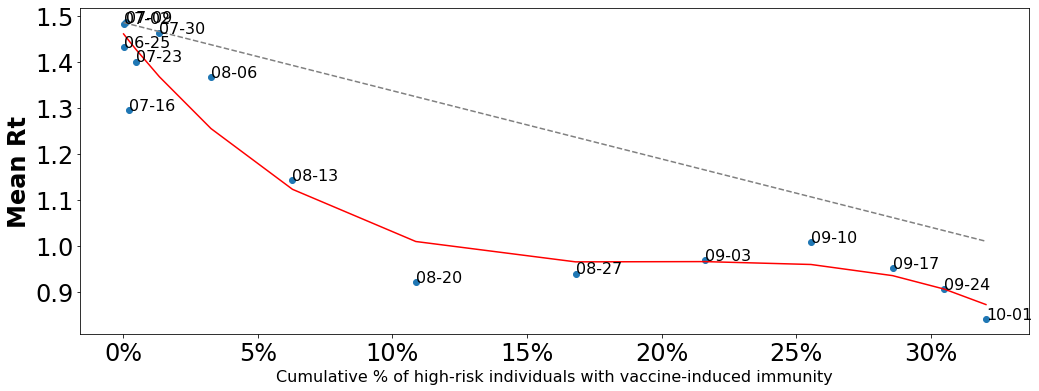

In [728]:
fig,ax1 = plt.subplots(figsize=(17,6),facecolor='w')
#ax1.axhline(y=1.0, color='k', linestyle='dashed', alpha = 0.6)

tck_s = splrep(combined_vac_df.cm_perc, combined_vac_df.mean_percent_x, s=len(combined_vac_df.cm_perc))
plt.plot(combined_vac_df.cm_perc, BSpline(*tck_s)(combined_vac_df.cm_perc), '-',color = "r", label=f's={len(combined_vac_df.cm_perc)}')

x = combined_vac_df.cm_perc
y = -(1.485519 * x*0.01) + 1.485519
plt.plot(x,y, color = "grey", linestyle = "dashed")
#ax1.text(.5, .65, 'y = -(1.486x)+ 1.486',
#        transform=ax1.transAxes, size = 18)


corr, _ = pearsonr(combined_vac_df.cm_perc, combined_vac_df.mean_percent_x)

r, p = sp.stats.pearsonr(combined_vac_df.cm_perc, combined_vac_df.mean_percent_x)
#ax1.text(.2, .75, 'r={:.2f}, p={:.2g}'.format(r, p),
#        transform=ax1.transAxes)


n = combined_vac_df.Date

ax1.scatter(x="cm_perc", y="mean_percent_x", data = combined_vac_df)


for i, txt in enumerate(n):
    ax1.annotate(str(txt)[5:10], (combined_vac_df.cm_perc[i], combined_vac_df.mean_percent_x[i]), size = 16)

#sns.regplot(x="cm_perc", y="mean_percent_x", data = combined_vac_df, scatter=True, ax=ax1, color='steelblue', line_kws={'linestyle': '--', 'linewidth': 1}, label='Pearson Correlation: {corr:.2f}')
#ax1.line()
vals = ax1.get_xticks()/100
ax1.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
plt.ylabel("Mean Rt", size = 24,  fontweight='bold')
plt.xlabel("Cumulative % of high-risk individuals with vaccine-induced immunity", size = 16)
plt.xticks(size = 24)
plt.yticks(size = 24)
#pyplot.phase_spectrum( combined_vac_df.mean_percent_x, color ='green')

plt.savefig("../figures/rt_vs_vaccine.png", pad_inches = 0)

plt.show()

## now we separate out Rt by contribution 

In [615]:
smoothed_intro_rt_no_intro['Contribution'] = "Local"
smoothed_intro_rt['Contribution'] = "Local + Intoductions"
smoothed_intro_rt_na = smoothed_intro_rt[smoothed_intro_rt.deme_x == "North America"]
smoothed_intro_rt_no_intro_na = smoothed_intro_rt_no_intro[smoothed_intro_rt_no_intro.deme_x == "North America"]


In [618]:
combined_rt_na = pd.concat([ smoothed_intro_rt_na, smoothed_intro_rt_no_intro_na], ignore_index=True)
combined_rt_all = pd.concat([ smoothed_intro_rt, smoothed_intro_rt_no_intro], ignore_index=True)


In [619]:
combined_rt.Contribution.value_counts()

Local + Intoductions    33
Local                   33
Name: Contribution, dtype: int64

In [620]:
combined_rt_na = combined_rt_na[combined_rt_na.date > "2022-05-30"]
combined_rt_all = combined_rt_all[combined_rt_all.date > "2022-05-30"]

In [621]:
stream_rt = alt.Chart(combined_rt_na, title = "North American Rt by Contribution").mark_area(interpolate='monotone', opacity = 0.8 ,color = "#f58518", clip = True).encode(
    alt.X('date:T', axis=alt.Axis(title="",tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('mean_percent_x',axis=alt.Axis(title="Estimated Rt", grid=False),stack = False, scale=alt.Scale(domain=(0, 2.5))),
    #alt.Y2('upper_hpd_log_50' ), 
    alt.Color('Contribution:N',legend=alt.Legend(title= "Contribution",offset = -180, labelFontSize = 16, titleFontSize = 20))#, scale=alt.Scale(domain = ['Local',  "lo"], range = ["#4c90c0",  "#df4327"]))
).properties(
    width=800,
    height=300
)

#.transform_filter(
#    (datum.mean_percent >0) & (datum.mean_percent < 2.5)
#)

In [622]:
contribution_plot = stream_rt + one_line
(stream_rt + one_line).configure_axis(
    labelFontSize=20,
    titleFontSize=20
)


alt.LayerChart(...)

In [683]:
stream_graph_all =  alt.Chart(combined_rt_all, title = "").mark_area(interpolate='monotone', opacity = 0.8 ,color = "#f58518", clip = True).encode(
    alt.X('date:T', axis=alt.Axis(title="",tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('mean_percent_x',axis=alt.Axis(title="Estimated Rt", grid=False),stack = False, scale=alt.Scale(domain=(0, 2.5))),
    #alt.Y2('upper_hpd_log_50' ), 
    alt.Color('Contribution:N',legend=alt.Legend(title= "Contribution",offset = -180, labelFontSize = 16, titleFontSize = 20)),
    alt.Row("deme_x:N",
        header=alt.Header(labelFontSize=20))
).properties(
    width=800,
    height=300
).transform_filter(datum.deme_x != "Central Europe")

stream_graph_all.configure_view(
    strokeWidth=0
).configure_title(
    anchor='start', fontSize= 35
).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
    labelFontSize = 30)


alt.Chart(...)

In [687]:
#creating a joint figure for manuscript!
# Add labels to each chart
contribution_plot = contribution_plot.properties(title='A')
vac_comb = vac_comb.properties(title='B')

combined_plot = alt.vconcat(contribution_plot, vac_comb,  spacing=50).resolve_scale(x='shared', y = "shared", color ='independent')


combined_plot.configure_view(
    strokeWidth=0
).configure_title(
    anchor='start', fontSize= 35
).configure_axis(
    labelFontSize=22,
    titleFontSize=22
).configure_legend(
     labelFontSize=28,
    titleFontSize=28
).transform_filter(
    (datum.date > "2022-05-25") # (datum.upper_hpd_log_95 < 4)
)





alt.VConcatChart(...)

In [91]:
## Now we calculate the percent of RT that is influenced by introductions

In [92]:
rt_local_intro_northamerica_df = rt_local_and_intro_df.filter(regex='.NorthAmerica.')
rt_local_northamerica_df = rt_local_df.filter(regex='.NorthAmerica.')

In [93]:
rt_local_intro_northamerica_df

,rt.NorthAmerica.0,rt.NorthAmerica.1,rt.NorthAmerica.2,rt.NorthAmerica.3,rt.NorthAmerica.4,rt.NorthAmerica.5,rt.NorthAmerica.6,rt.NorthAmerica.7,rt.NorthAmerica.8,rt.NorthAmerica.9,...,rt.NorthAmerica.31,rt.NorthAmerica.32,rt.NorthAmerica.33,rt.NorthAmerica.34,rt.NorthAmerica.35,rt.NorthAmerica.36,rt.NorthAmerica.37,rt.NorthAmerica.38,rt.NorthAmerica.39,rt.NorthAmerica.40
0,0.893817,0.910369,0.426532,0.424203,0.417347,0.889214,1.040601,1.022064,1.005544,0.828532,...,1.0,2.706753,2.706753,2.706753,1.0,1.0,1.0,1.0,1.0,1.0
1,0.898943,0.914714,0.618004,0.615408,0.607760,0.894557,1.669529,1.647509,1.627848,0.836671,...,1.0,2.771415,2.771415,2.771415,1.0,1.0,1.0,1.0,1.0,1.0
2,0.898943,0.914714,0.919933,0.916829,0.907678,0.894557,1.066803,1.048975,1.033079,0.836671,...,1.0,2.771415,2.771415,2.771415,1.0,1.0,1.0,1.0,1.0,1.0
3,0.902126,0.917411,0.914370,0.911375,0.902543,0.897874,1.213053,1.194731,1.178384,0.841732,...,1.0,2.978928,2.978928,2.978928,1.0,1.0,1.0,1.0,1.0,1.0
4,0.906140,0.920810,0.470637,0.468498,0.462195,0.902058,1.247544,1.229756,1.213879,0.848122,...,1.0,2.978928,2.978928,2.978928,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17556,0.887890,0.905343,0.926305,0.922841,0.912634,0.883038,1.096094,1.076019,1.058132,0.819140,...,1.0,2.968047,2.968047,2.968047,1.0,1.0,1.0,1.0,1.0,1.0
17557,0.887890,0.905343,0.240853,0.238888,0.233113,0.883038,1.161185,1.140562,1.122182,0.819140,...,1.0,2.949306,2.949306,2.949306,1.0,1.0,1.0,1.0,1.0,1.0
17558,0.887890,0.905343,1.118480,1.114701,1.103562,0.883038,1.141352,1.120895,1.102664,0.819140,...,1.0,2.949306,2.949306,2.949306,1.0,1.0,1.0,1.0,1.0,1.0
17559,0.910507,0.924508,0.724594,0.722134,0.714880,0.906610,1.538021,1.519315,1.502604,0.855085,...,1.0,2.545739,2.545739,2.545739,1.0,1.0,1.0,1.0,1.0,1.0


In [94]:
rt_diff_df = rt_local_northamerica_df.div(rt_local_intro_northamerica_df.values)

In [95]:
rt_df_summary = generate_rt_summary_df(rt_diff_df)

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/2004646667.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/2004646667.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/2004646667.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9222/2004646667.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


In [96]:
rt_df_summary['days'] = rt_df_summary.interval.astype(int) *7
rt_df_summary['date'] = dt.strptime("2023-01-03",  "%Y-%m-%d") - rt_df_summary.days.map(timedelta)
rt_df_summary = rt_df_summary[rt_df_summary.date >"2022-06-17"]
rt_df_summary.date = rt_df_summary.date.astype(str)

In [97]:
line = alt.Chart(rt_df_summary, title = "North America" ).mark_area( interpolate='monotone', opacity = 1 ,color = "#f58518").encode(
    alt.X('date:T', axis=alt.Axis(title="Date", grid=False,format="%B %Y")),
    alt.Y('lower_hpd_log_50',axis=alt.Axis(title="Percent of Rt due to Introductions ", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('upper_hpd_log_50' )
).properties(
    width=850,
    height=300
).transform_filter(
   (datum.lower_hpd_log_50 >0) #& (datum.upper_hpd_log_50 < 4)
)
band = alt.Chart(rt_df_summary).mark_area(
    opacity=0.3, interpolate='monotone', color = "#f58518"
).encode(
    alt.X('date:T', axis=alt.Axis(title="Date", grid=False)),
    alt.Y('lower_hpd_log_95', axis=alt.Axis(title="", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('upper_hpd_log_95')
).properties(
    width=850,
    height=300
).transform_filter(
    (datum.lower_hpd_log_95 >0) #& (datum.upper_hpd_log_95 < 4)
)

rt_diff_plot = line + band +one_line
(vac_plot + (rt_diff_plot)).resolve_scale(y="independent")

alt.LayerChart(...)